## Import Statements

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor


## Read in Data

In [2]:
df = pd.read_csv('../../data/preprocessed_prescribed_data.csv')
df = df[df['Label'] == 1];
df.drop(columns=['Label', 'TaskName', 'Odometer', 'IsHybrid'], inplace=True) # Drop TaskName as all are 'Logbook'
df.head()

,Make,Model,Year,FuelType,EngineSize,Transmission,DriveType,Distance,Months,AdjustedPrice
0,ISUZU,ISUZU F-SERIES,2018,Diesel,NaN,Auto,2WD,220000.0,NaN,1266.0
1,MAXICUBE,MAXICUBE 24 PALLET,2017,NaN,NaN,NaN,NaN,625000.0,NaN,288.0
2,FORD,FORD TRANSIT,2021,Diesel,2.0,Auto,2WD,90000.0,NaN,414.0
4,HINO,HINO 300,2021,Diesel,NaN,Auto,NaN,40000.0,NaN,1895.0
5,EQUIPMENT,EQUIPMENT VAWTRA,2014,NaN,NaN,NaN,4WD,740000.0,NaN,337.0


In [3]:
X = df.drop(columns=["AdjustedPrice"])  
y = df["AdjustedPrice"]       

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
# Identify feature types
cat_features = X_train.select_dtypes(include=["object", "category"]).columns

In [6]:
for col in X_train.select_dtypes(include='object').columns:
     X_train[col] = X_train[col].fillna("missing")

for col in X_test.select_dtypes(include='object').columns:
   X_test[col] = X_test[col].fillna("missing")

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

In [8]:
cat_feature_indices = [0, 1, 3, 5, 6]
 
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'iterations': [1000, 1500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20]
}

model = CatBoostRegressor(
    cat_features=cat_feature_indices,
    eval_metric='MAPE',
    od_type='Iter',
    od_wait=50,
    random_seed=42,
    verbose=100
)

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=25, cv=3, scoring='neg_mean_absolute_percentage_error')

random_search.fit(X_train, y_train, 
                  verbose=False)

best_model = random_search.best_estimator_



print("Best params:", random_search.best_params_)
print("Best score:", -random_search.best_score_)

Best params: {'subsample': 1.0, 'min_child_samples': 5, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 10, 'colsample_bylevel': 0.8}
Best score: 0.3763872594518369


In [9]:


from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")


0:	learn: 1.0399239	total: 4.82ms	remaining: 4.81s
100:	learn: 0.4788123	total: 352ms	remaining: 3.13s
200:	learn: 0.3718363	total: 756ms	remaining: 3.01s
300:	learn: 0.3335889	total: 1.19s	remaining: 2.77s
400:	learn: 0.3125316	total: 1.65s	remaining: 2.47s
500:	learn: 0.2971954	total: 2.12s	remaining: 2.11s
600:	learn: 0.2847434	total: 2.58s	remaining: 1.71s
700:	learn: 0.2731615	total: 3.03s	remaining: 1.29s
800:	learn: 0.2654235	total: 3.48s	remaining: 864ms
900:	learn: 0.2577313	total: 3.94s	remaining: 433ms
999:	learn: 0.2508567	total: 4.4s	remaining: 0us
MAE: 284.6741287901732
RMSE: 499.5104654368481
MAPE: 35.66%


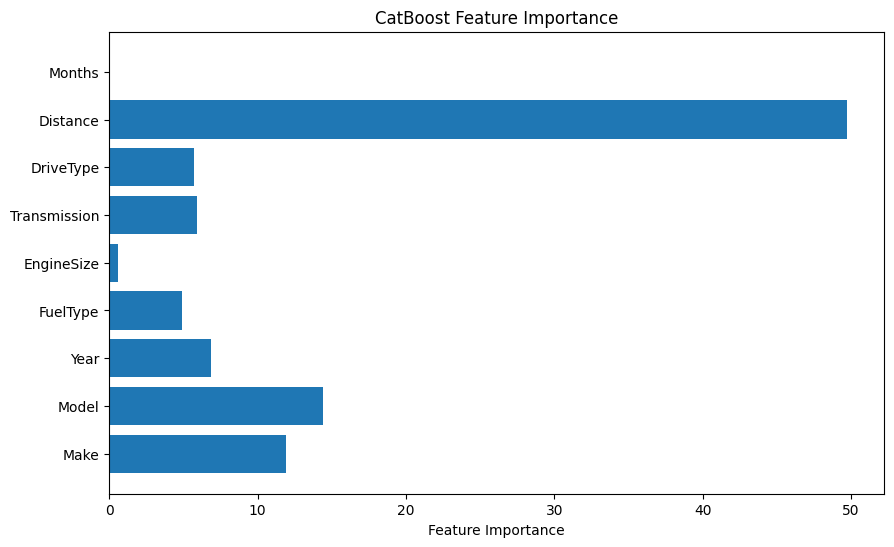

In [10]:
importance = best_model.get_feature_importance()
feature_names = X_train.columns  # or your list of feature names

plt.figure(figsize=(10,6))
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()